# Workshop 1: Introduction to Quantitative Trading
## Predicting Stock Prices with Simple Statistical Methods

Welcome to this introductory workshop on quantitative finance! In this workshop, we'll explore:

1. **Exploratory Data Analysis (EDA)** - Understanding our stock price data
2. **Autocorrelation** - How past prices relate to future prices
3. **Exponentially Weighted Moving Averages (EWMA)** - Creating trading signals
4. **Statistical Testing** - Validating our signals with t-statistics
5. **Backtesting** - Testing our strategy on historical data
6. **Signal to Trades** - Converting predictions into actual trading decisions

We'll focus on a single stock (AAPL) and try to predict the next timestep's price movement using only historical price data.

## Step 1: Load and Explore the Dataset

Let's start by loading the financial data from Kaggle and exploring what's available.

In [114]:
#We make a fake dataset with some autocorrelated returns so that EWMA method works well
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)
n = 10000
# Generate autocorrelated returns
returns = np.zeros(n)
for t in range(1, n):
    returns[t] = 0.8 * returns[t-1] + np.random.normal(0, 1)
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
data = pd.DataFrame(data=returns, index=dates, columns=['Returns'])
data['Close'] = 100 + data['Returns'].cumsum()

In [115]:
data.reset_index(inplace=True)

In [116]:
data.rename(columns={'index': 'Date'}, inplace=True)

In [117]:
data.drop(columns=['Returns'], inplace=True)

In [120]:
synthetic_data = data.copy()

In [119]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adhoppin/financial-data")

print("Path to dataset files:", path)

Path to dataset files: /home/de7281/.cache/kagglehub/datasets/adhoppin/financial-data/versions/1


## Step 2: Extract AAPL Data

Now let's filter the dataset to focus on Apple (AAPL) stock and prepare it for analysis.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df_aapl = pd.read_csv(f"{path}/{'Financial Data'}/stocks/AAPL.csv")

In [26]:
train_test_split = 0.8

In [162]:
df_train = df_aapl.iloc[:int(len(df_aapl)*train_test_split)].copy()
df_test = df_aapl.iloc[int(len(df_aapl)*train_test_split):].copy()

## Step 3: Exploratory Data Analysis (EDA)

Let's explore the AAPL stock data to understand its characteristics, trends, and patterns.

In [28]:
# Explore the dataset structure
print("Column names:")
print(df_train.columns.tolist())
print(f"\nData types:")
print(df_train.dtypes)
print(f"\nMissing values:")
print(df_train.isnull().sum())

Column names:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'YTD Gains']

Data types:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Symbol        object
YTD Gains    float64
dtype: object

Missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Symbol       0
YTD Gains    0
dtype: int64


In [29]:
# Basic statistics
print("Summary Statistics:")
print(df_train.describe())

# Check for missing values
print(f"\nMissing values in AAPL data:")
print(df_train.isnull().sum())

Summary Statistics:
              Open         High          Low        Close        Volume  \
count  4116.000000  4116.000000  4116.000000  4116.000000  4.116000e+03   
mean     15.863205    16.010965    15.706453    15.862751  4.868262e+08   
std      14.578341    14.699947    14.458195    14.582435  4.022788e+08   
min       0.231964     0.235536     0.227143     0.234286  4.590360e+07   
25%       3.087322     3.144197     3.044018     3.081786  1.883643e+08   
50%      12.013572    12.138928    11.910179    12.016428  3.800020e+08   
75%      25.767499    26.168751    25.657500    25.793125  6.582499e+08   
max      57.695000    58.367500    57.445000    58.017502  3.372970e+09   

         YTD Gains  
count  4116.000000  
mean     60.989784  
std      56.986456  
min      -0.084438  
25%      11.043260  
50%      45.958802  
75%      99.796526  
max     225.725638  

Missing values in AAPL data:
Date         0
Open         0
High         0
Low          0
Close        0
Volume    

In [35]:
date_col = 'Date'
price_col = 'Close'


<Axes: title={'center': 'AAPL Closing Prices - Training Set'}, xlabel='Date'>

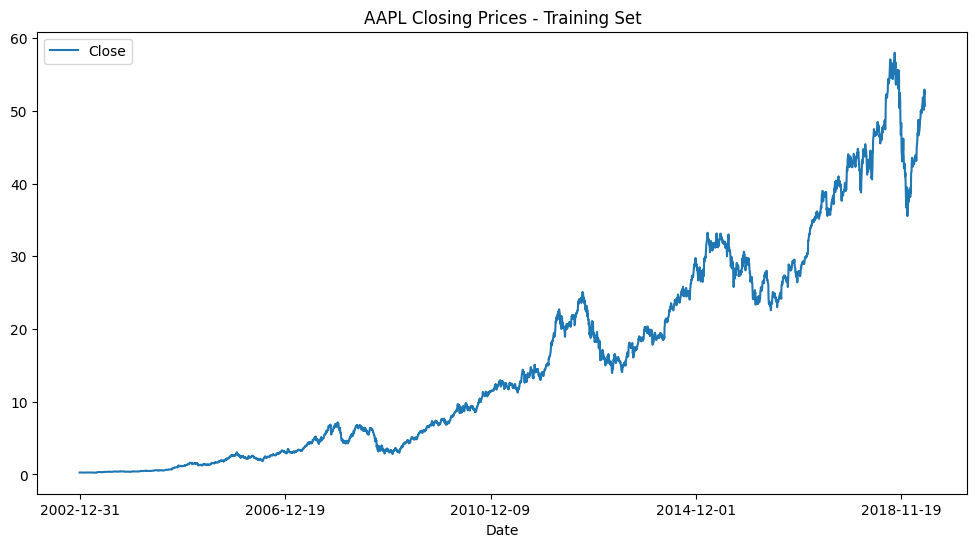

In [36]:
df_train.plot(x=date_col, y=price_col, title='AAPL Closing Prices - Training Set', figsize=(12, 6))

<Axes: title={'center': 'AAPL Closing Price Distribution - Training Set'}, ylabel='Frequency'>

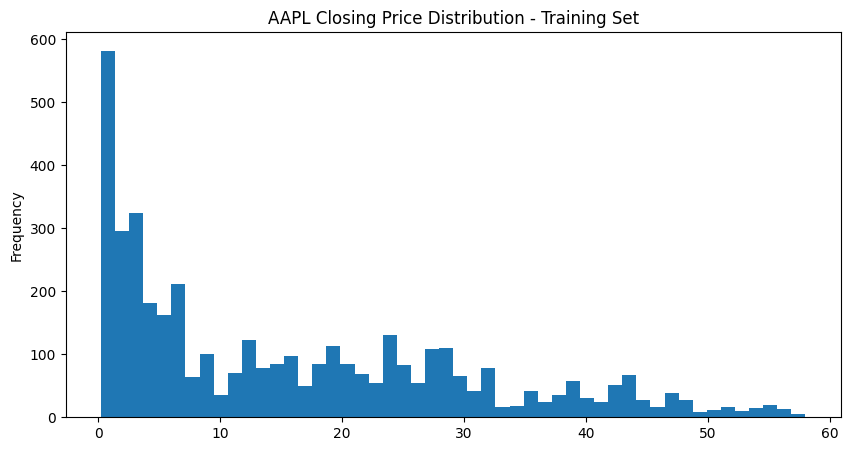

In [37]:
df_train[price_col].plot(kind='hist', bins=50, title='AAPL Closing Price Distribution - Training Set', figsize=(10, 5))

What we want to know is not the next price, but the next CHANGE in price! There's no point predicting prices, when we can predict RETURNS.

In [66]:
# Get returns data
df_train['Returns'] = df_train[price_col].pct_change()


<Axes: title={'center': 'AAPL Daily Returns - Training Set'}, xlabel='Date'>

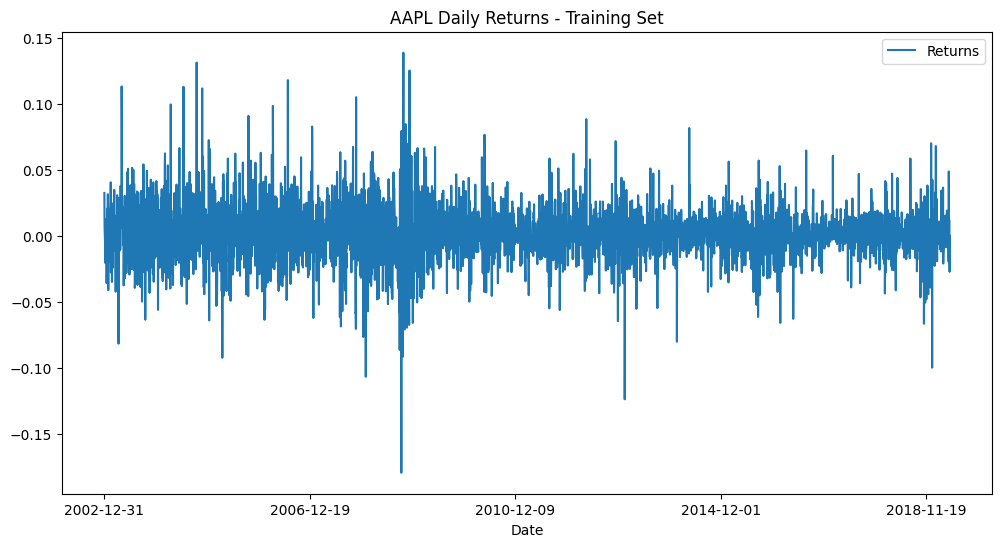

In [67]:
df_train.plot(x=date_col, y='Returns', title='AAPL Daily Returns - Training Set', figsize=(12, 6))

<Axes: title={'center': 'AAPL Daily Returns Distribution - Training Set'}, ylabel='Frequency'>

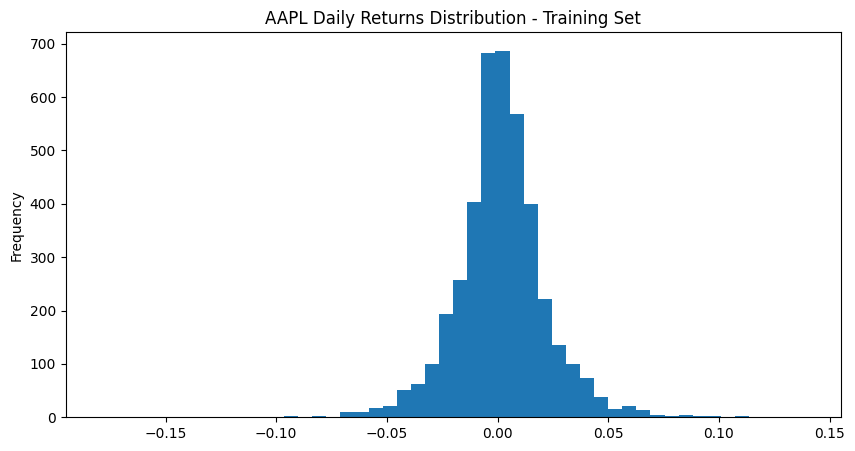

In [69]:
df_train['Returns'].plot(kind='hist', bins=50, title='AAPL Daily Returns Distribution - Training Set', figsize=(10, 5))

## Step 4: The Simplest Possible Next Price

In [72]:
# Make a column that predicts the next day's return from the previous

df_train['Pred_Simple'] = df_train['Returns'].shift(1)

In [73]:
df_train[['Returns', 'Pred_Simple']]

,Returns,Pred_Simple
0,NaN,NaN
1,0.032799,NaN
2,0.006754,0.032799
3,0.000000,0.006754
4,-0.003352,0.000000
...,...,...
4111,-0.006508,0.049086
4112,0.012431,-0.006508
4113,-0.015443,0.012431
4114,-0.026957,-0.015443


<Axes: title={'center': 'AAPL Returns vs Simple Prediction - Training Set'}, xlabel='Date'>

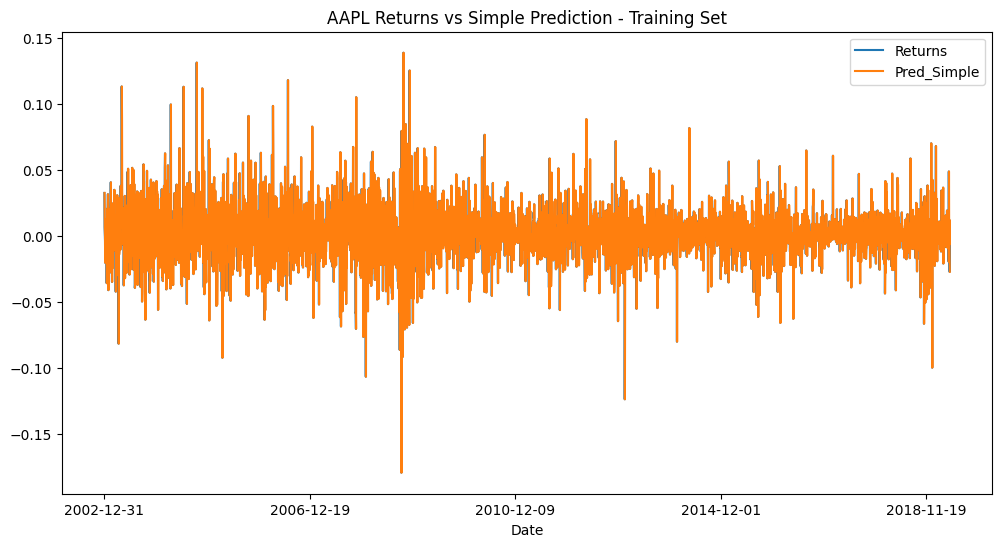

In [75]:
df_train.plot(x=date_col, y=['Returns', 'Pred_Simple'], title='AAPL Returns vs Simple Prediction - Training Set', figsize=(12, 6))

Wow, we did really good???

## Step 5: Evaluating our Method

Not so fast...

<Axes: title={'center': 'AAPL Returns vs Simple Prediction Scatter - Training Set'}, xlabel='Pred_Simple', ylabel='Returns'>

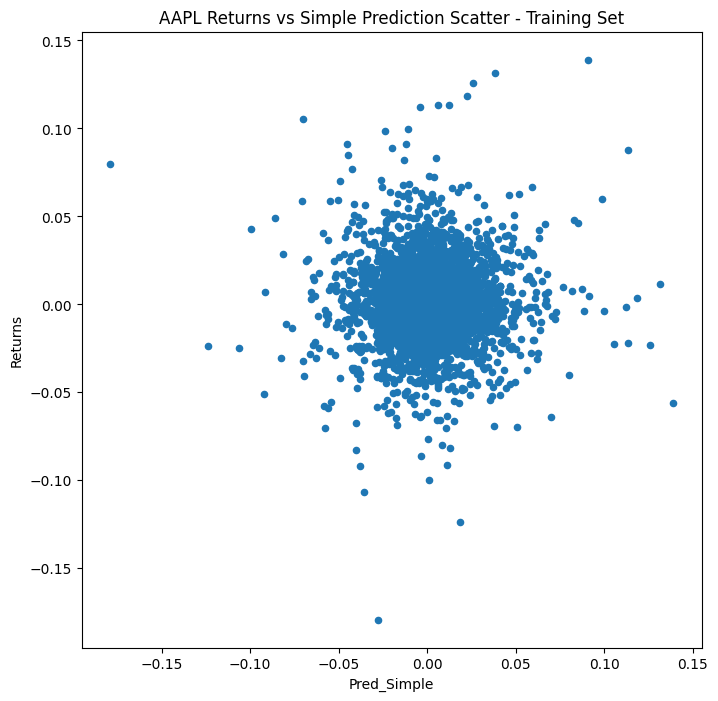

In [77]:
df_train[['Returns', 'Pred_Simple']].plot(kind='scatter', x='Pred_Simple', y='Returns', title='AAPL Returns vs Simple Prediction Scatter - Training Set', figsize=(8, 8))

In [86]:
df_train[['Returns', 'Pred_Simple']].corr()

,Returns,Pred_Simple
Returns,1.000000,0.004739
Pred_Simple,0.004739,1.000000


In [78]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [81]:
mse(df_train.dropna()['Returns'], df_train.dropna()['Pred_Simple'][:-1])

np.float64(0.0008845331783834335)

In [61]:
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [83]:
r2(df_train.dropna()['Returns'], df_train.dropna()['Pred_Simple'])

np.float64(-0.9906527819745368)

## Step 6: A Better Method -- Moving Average

We can do better with an average over multiple previous data points...

In [87]:
# We make a column 'Pred_Avg' that averages the k previous data points returns
k = 5
df_train['Pred_Avg'] = df_train['Returns'].shift(1).rolling(window=k).mean()

In [89]:
df_train[['Returns', 'Pred_Avg']].head(10)

,Returns,Pred_Avg
0,NaN,NaN
1,0.032799,NaN
2,0.006754,NaN
3,0.000000,NaN
4,-0.003352,NaN
5,-0.020205,NaN
6,0.008937,0.003199
7,0.002724,-0.001573
8,-0.006114,-0.002379
9,-0.001367,-0.003602


<Axes: title={'center': 'AAPL Returns vs Average Prediction - Training Set'}, xlabel='Date'>

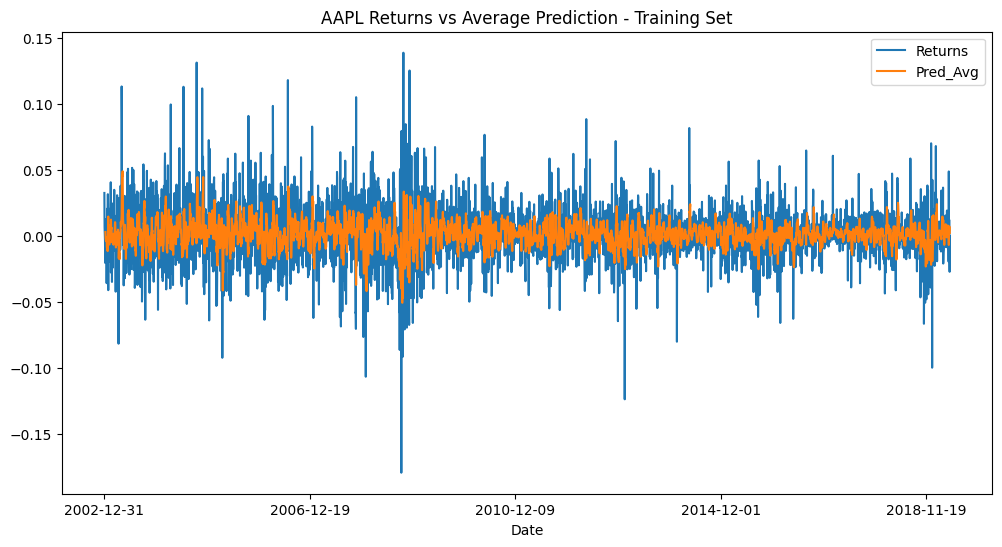

In [90]:
df_train.plot(x=date_col, y=['Returns', 'Pred_Avg'], title='AAPL Returns vs Average Prediction - Training Set', figsize=(12, 6))

<Axes: title={'center': 'AAPL Returns vs Average Prediction Scatter - Training Set'}, xlabel='Pred_Avg', ylabel='Returns'>

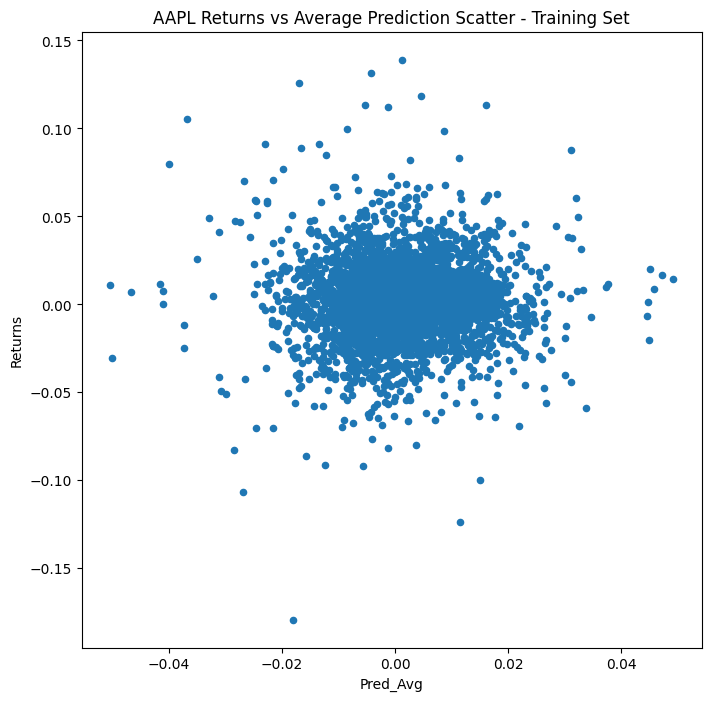

In [91]:
df_train[['Returns', 'Pred_Avg']].plot(kind='scatter', x='Pred_Avg', y='Returns', title='AAPL Returns vs Average Prediction Scatter - Training Set', figsize=(8, 8))

In [92]:
r2(df_train.dropna()['Returns'], df_train.dropna()['Pred_Avg'])

np.float64(-0.18297421767616884)

## Step 7: An Even Better Method -- EWMA

Why weight all points the same? We can do better!

In [93]:
# We make a column 'Pred_EWMA' that uses exponentially weighted moving average to predict returns
alpha = 0.3
df_train['Pred_EWMA'] = df_train['Returns'].shift(1).ewm(alpha=alpha).mean()

In [94]:
df_train[['Returns', 'Pred_EWMA']].head(10)

,Returns,Pred_EWMA
0,NaN,NaN
1,0.032799,NaN
2,0.006754,0.032799
3,0.000000,0.017478
4,-0.003352,0.009497
5,-0.020205,0.004424
6,0.008937,-0.004457
7,0.002724,0.000097
8,-0.006114,0.000956
9,-0.001367,-0.001295


<Axes: title={'center': 'AAPL Returns vs EWMA Prediction - Training Set'}, xlabel='Date'>

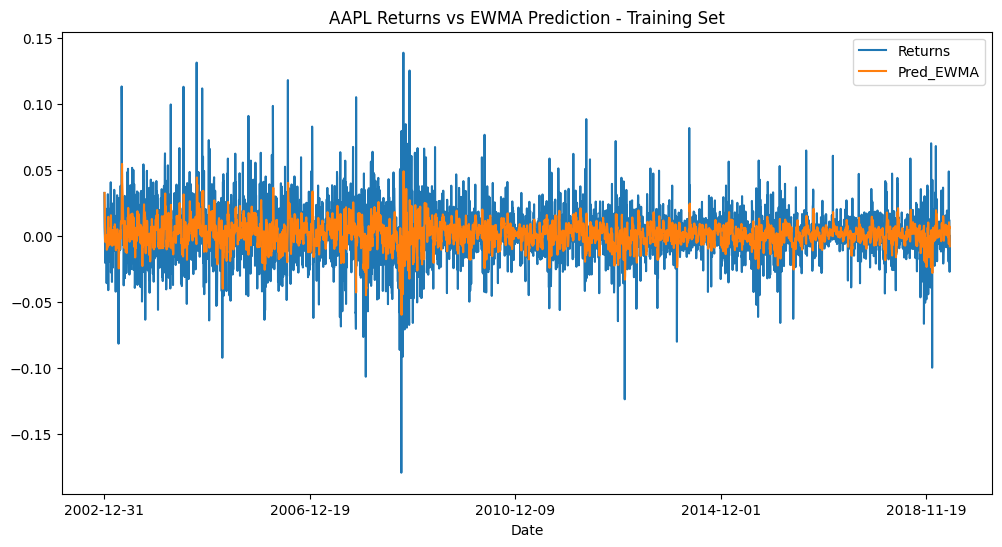

In [95]:
df_train.plot(x=date_col, y=['Returns', 'Pred_EWMA'], title='AAPL Returns vs EWMA Prediction - Training Set', figsize=(12, 6))

<Axes: title={'center': 'AAPL Returns vs EWMA Prediction Scatter - Training Set'}, xlabel='Pred_EWMA', ylabel='Returns'>

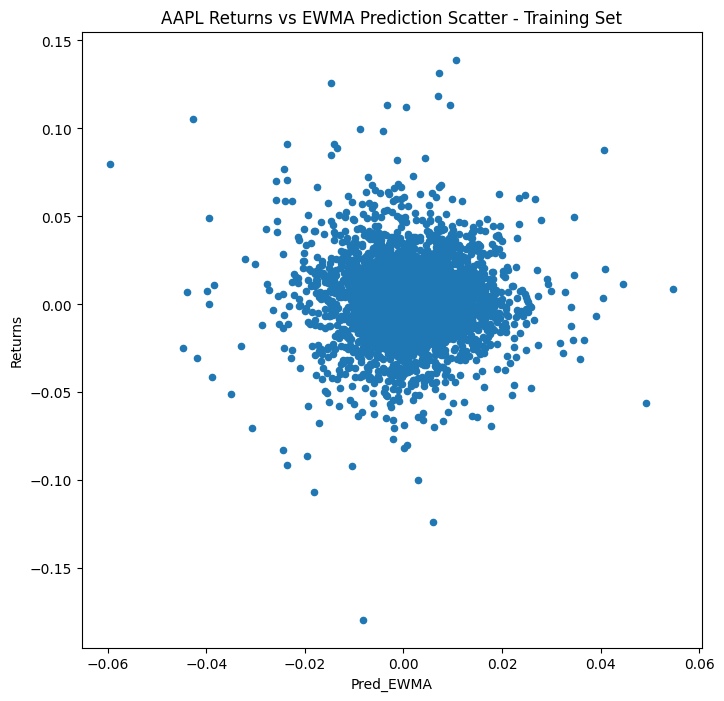

In [96]:
df_train[['Returns', 'Pred_EWMA']].plot(kind='scatter', x='Pred_EWMA', y='Returns', title='AAPL Returns vs EWMA Prediction Scatter - Training Set', figsize=(8, 8))

In [98]:
df_train[['Returns', 'Pred_Avg']].corr()

,Returns,Pred_Avg
Returns,1.000000,0.017121
Pred_Avg,0.017121,1.000000


In [147]:
df_train[['Returns', 'Pred_EWMA']].corr()

,Returns,Pred_EWMA
Returns,1.000000,-0.001841
Pred_EWMA,-0.001841,1.000000


In [148]:
r2(df_train.dropna()['Returns'], df_train.dropna()['Pred_EWMA'])

np.float64(-0.17736630105593276)

In [151]:
np.corrcoef(np.sign(df_train.dropna()['Returns']), np.sign(df_train.dropna()['Pred_EWMA']))

array([[1.        , 0.00479792],
       [0.00479792, 1.        ]])

## Step 8: Trading off of our "Signal"

In [138]:
def compute_pnl(returns, predictions):
    pnl = np.sign(predictions) * returns
    cumulative_pnl = np.cumsum(pnl)
    return cumulative_pnl

In [153]:
df_train[['Returns', 'Pred_Simple']]

,Returns,Pred_Simple
0,NaN,NaN
1,0.032799,NaN
2,0.006754,0.032799
3,0.000000,0.006754
4,-0.003352,0.000000
...,...,...
4111,-0.006508,0.049086
4112,0.012431,-0.006508
4113,-0.015443,0.012431
4114,-0.026957,-0.015443


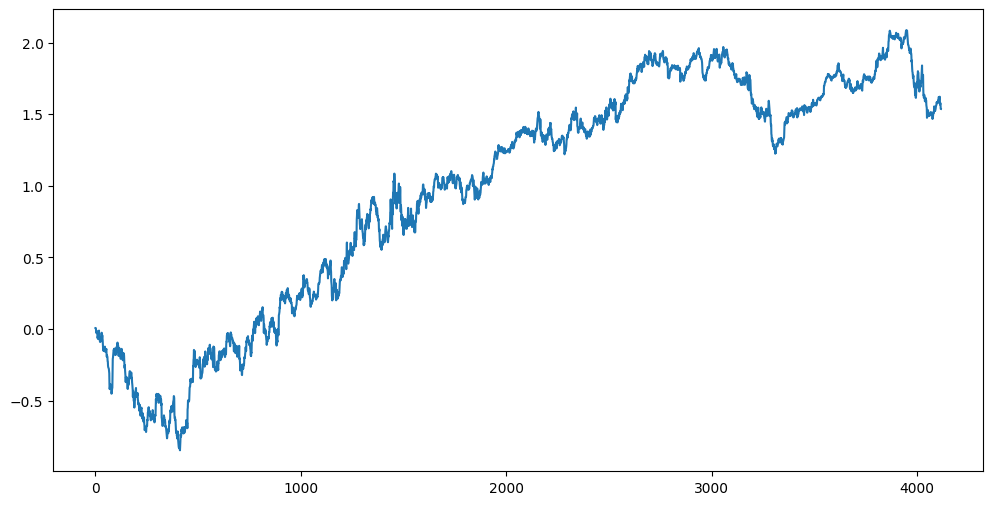

In [139]:
cum_pnl = compute_pnl(df_train['Returns'].dropna(), df_train['Pred_EWMA'].dropna())
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl, label='Cumulative PnL (EWMA Strategy)')

In [145]:
def tstat(pnl):
    return np.sum(pnl) / np.sqrt(np.sum(pnl**2))

In [146]:
tstat(compute_pnl(df_train['Returns'].dropna(), df_train['Pred_EWMA'].dropna()))

np.float64(49.21183261198437)

Wait... why does this make money???

In [154]:
df_test['Returns'] = df_test[price_col].pct_change()
df_test['Pred_EWMA'] = df_test['Returns'].shift(1).ewm(alpha=alpha).mean()
cum_pnl_test = compute_pnl(df_test['Returns'].dropna(), df_test['Pred_EWMA'].dropna())

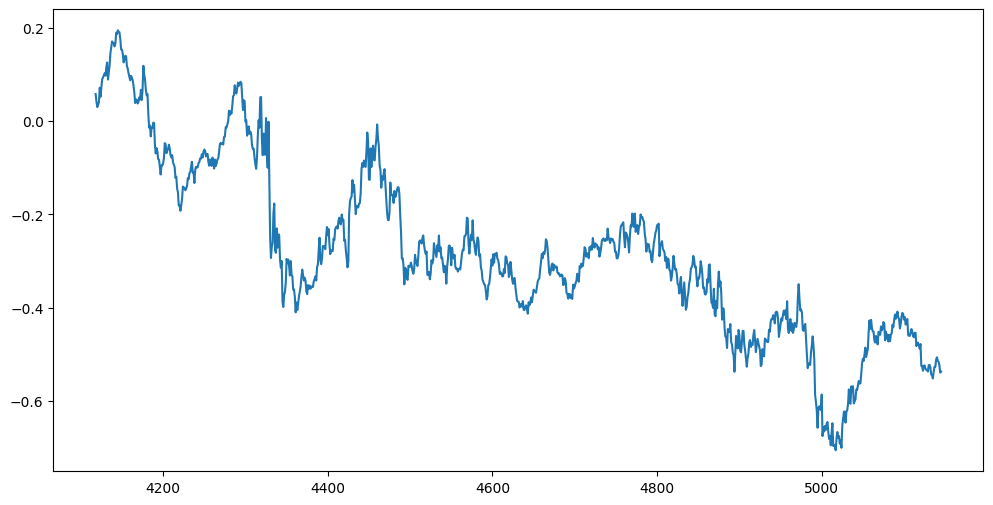

In [155]:
cum_pnl_test_plot = plt.figure(figsize=(12, 6))
plt.plot(cum_pnl_test, label='Cumulative PnL (EWMA Strategy) - Test Set')

## Step 9: Improvements?

In [160]:
def make_ewma_pred(returns, alpha):
    return returns.shift(1).ewm(alpha=alpha).mean()

In [161]:
# Hyperparameter search over alpha on the test set
alphas = np.linspace(0.01, 0.5, 50)
best_alpha = None
best_tstat = -np.inf
for alpha in alphas:
    preds = make_ewma_pred(df_test['Returns'], alpha)
    pnl = compute_pnl(df_test['Returns'].dropna(), preds.dropna())
    current_tstat = tstat(pnl)
    if current_tstat > best_tstat:
        best_tstat = current_tstat
        best_alpha = alpha
print(f"Best alpha: {best_alpha}, Best t-stat: {best_tstat}")

Best alpha: 0.08, Best t-stat: 29.818929504590855


Is this result real?